In [1]:
import autograd

import autograd.numpy as np

import autograd.scipy as sp

from bnpmodeling_runjingdev.modeling_lib import my_slogdet3d

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as precond_lib

from copy import deepcopy

import paragami

import matplotlib.pyplot as plt
%matplotlib inline


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
dim = 4

# Check log-partition function

In [3]:
mean = np.random.randn(dim)
info = np.random.randn(dim, dim)
info = np.dot(info, info.transpose())

In [4]:
# get paragami objects
mvn_params_paragami, mvn_nat_params_paragami = \
    precond_lib.get_mvn_paragami_objects(dim)

In [5]:
# dictionary of parameters
mvn_params_dict = mvn_params_paragami.random()
mvn_params_dict['mean'] = mean
mvn_params_dict['info'] = info

In [6]:
# vector of free canonical parameters
mvn_free_params = mvn_params_paragami.flatten(mvn_params_dict, free = True)

# vector of natural parameters
nat_vec = precond_lib.get_nat_vec(mvn_free_params, mvn_params_paragami, mvn_nat_params_paragami)

In [7]:
precond_lib.get_mvn_log_partition(nat_vec, mvn_nat_params_paragami)

3.0554436617100613

In [8]:
# get gradient of log partition function
get_grad_log_part = autograd.grad(precond_lib.get_mvn_log_partition)
grad_log_part = get_grad_log_part(nat_vec, mvn_nat_params_paragami)

In [9]:
# fold gradient into dictionary
grad_log_part_folded = mvn_params_paragami.fold(grad_log_part, free = False, validate_value = False)

In [10]:
# get expectations of sufficient statistics
e_x = mean
e_x2 = np.linalg.inv(info) + np.einsum('i, j -> ij', mean, mean)

In [11]:
# check they match with gradient of log partition
np.abs(e_x - grad_log_part_folded['mean']).max()

3.042011087472929e-14

In [12]:
np.abs(-e_x2 - grad_log_part_folded['info']).max()

1.0196288258157438e-12

# Check Fisher information

In [13]:
fishers_info = precond_lib.get_fishers_info(mvn_free_params, dim)

In [14]:
# a slightly different way to get the fishers info

In [15]:
# dA / deta, eta being the natural pameters
get_dA_deta = autograd.grad(precond_lib.get_mvn_log_partition)
dA_deta = get_dA_deta(nat_vec, mvn_nat_params_paragami)

In [16]:
def get_log_partition_free_canon(mvn_free_param, mvn_params_paragami, mvn_nat_params_paragami): 
    # this is A(eta(theta)), where eta(theta) is the natural parameters as a function of the 
    # free canonical parameters 
    
    nat_vec = precond_lib.get_nat_vec(mvn_free_param, mvn_params_paragami, mvn_nat_params_paragami)
    return precond_lib.get_mvn_log_partition(nat_vec, mvn_nat_params_paragami)

In [17]:
get_dA2_dtheta2 = autograd.hessian(get_log_partition_free_canon)
dA2_dtheta2 = get_dA2_dtheta2(mvn_free_params, mvn_params_paragami, mvn_nat_params_paragami)

In [18]:
# this is d^2 eta / dtheta^2
get_deta2_dtheta2 = autograd.jacobian(precond_lib.get_jac_term, 0)
deta2_dtheta2 = get_deta2_dtheta2(mvn_free_params, mvn_params_paragami, mvn_nat_params_paragami)

In [19]:
# alternatively the fishers info can be computed as 
# d^2A/dtheta^2 - dA/deta d^2eta / dtheta^2
fishers_info2 = dA2_dtheta2 - np.einsum('j, jik -> ik', dA_deta, deta2_dtheta2)

In [20]:
np.abs(fishers_info - fishers_info2).max()

2.5399790525577044e-12

### We also check against sampling

In [21]:
def get_normal_logpdf(x, mean, info): 
    assert x.shape[1] == len(mean)
    assert info.shape[0] == len(mean)
    
    diff = x - mean[None, :]
    
    cross = np.einsum('ni, ij -> nj', diff, info)
    squared = np.einsum('nj, nj -> n', diff, cross)
    
    return -0.5 * squared + 0.5 * np.linalg.slogdet(info)[1]

In [22]:
def get_log_q(x, mvn_free_params, mvn_params_paragami): 
    mvn_params_dict = mvn_params_paragami.fold(mvn_free_params, free = True)
    
    mean = mvn_params_dict['mean']
    info = mvn_params_dict['info']
    
    return get_normal_logpdf(x, mean, info).mean()

In [23]:
x = np.random.multivariate_normal(mean, np.linalg.inv(info), 100000)

In [24]:
get_log_q(x, mvn_free_params, mvn_params_paragami)

-1.6454362478872464

In [25]:
get_est_fishers_info = autograd.hessian(get_log_q, argnum = 1)
est_fishers_info = - get_est_fishers_info(x, mvn_free_params, mvn_params_paragami)

In [26]:
np.abs(fishers_info - est_fishers_info).max()

0.12973566609736764

### Yet another way to get the fisher's info

In [27]:
get_score_fun = autograd.grad(get_log_q, argnum = 1)

In [28]:
n_samples = 10000
score_fun2_all = np.zeros((n_samples, len(mvn_free_params), len(mvn_free_params)))
for i in range(n_samples): 
    score_fun = get_score_fun(x[i:(i+1)], mvn_free_params, mvn_params_paragami)
    score_fun2_all[i] = np.einsum('i, j -> ij', score_fun, score_fun)

In [29]:
mean_score_fun2 = score_fun2_all.mean(0)

In [30]:
sd_score_fun2 = score_fun2_all.std(0)

In [31]:
zscores = ((fishers_info - mean_score_fun2) / (sd_score_fun2 / np.sqrt(n_samples)))

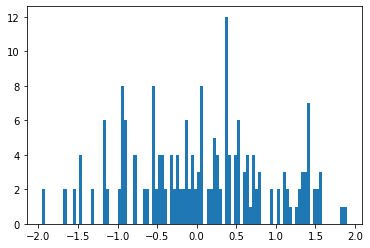

In [32]:
plt.hist(zscores.flatten(), bins = 100);

# OK, now we do it for the full set of vb_params

In [33]:
# get vb parameters
k_approx = 30
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)
vb_params_dict = vb_params_paragami.random()

vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [34]:
preconditioner = precond_lib.get_gmm_preconditioner(vb_free_params, vb_params_paragami).toarray()

In [35]:
fishers_info = np.linalg.inv(preconditioner)

### Check cluster parameters

In [36]:
for k in range(k_approx):
    bool_dict = vb_params_paragami.empty_bool(False)
    bool_dict['cluster_params']['centroids'][:, k] = True
    bool_dict['cluster_params']['cluster_info'][k] = True

    # get indices
    indx_cluster_params_k = vb_params_paragami.flat_indices(bool_dict, free = True)
    
    # get free parameters for this cluster
    mvn_params_dict['mean'] = vb_params_dict['cluster_params']['centroids'][:, k]
    mvn_params_dict['info'] = vb_params_dict['cluster_params']['cluster_info'][k]
    mvn_free_params_k = mvn_params_paragami.flatten(mvn_params_dict, free = True)
    
    assert (mvn_free_params_k == vb_free_params[indx_cluster_params_k]).all()
    
    # get fisher's info 
    fishers_info_k = precond_lib.get_fishers_info(mvn_free_params_k, dim)
    
    # compare with giant fisher's info matrix
    for i in range(len(indx_cluster_params_k)): 
        for j in range(len(indx_cluster_params_k)): 
            assert np.abs(fishers_info[indx_cluster_params_k[i], indx_cluster_params_k[j]] - 
                          fishers_info_k[i, j]).max() < 1e-12

In [37]:
def get_manual_fishers_info(free_params): 
    assert len(free_params) == 2
    return np.array([[np.exp(free_params[1]), 0], [0, 0.5]])

In [38]:
for k in range(k_approx - 1):
    bool_dict = vb_params_paragami.empty_bool(False)
    bool_dict['stick_params']['stick_propn_mean'][k] = True
    bool_dict['stick_params']['stick_propn_info'][k] = True

    # get indices
    indx_cluster_params_k = vb_params_paragami.flat_indices(bool_dict, free = True)
    
    fishers_info_k = get_manual_fishers_info(vb_free_params[indx_cluster_params_k])
    
    # compare with giant fisher's info matrix
    for i in range(len(indx_cluster_params_k)): 
        for j in range(len(indx_cluster_params_k)): 
            assert np.abs(fishers_info[indx_cluster_params_k[i], indx_cluster_params_k[j]] - 
                          fishers_info_k[i, j]).max() < 1e-3